In [ ]:
#default_exp augmentations

# augmentations

>Implmentation heavily inspired by Ignacio Oguiza - oguiza@gmail.com

In [ ]:
#export
import random
from functools import partial
from scipy.interpolate import CubicSpline
from torchtools.data import *
import pywt

In [ ]:
#export
import numpy as np
import torch

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.all import *

In [ ]:
#export
from torchtools.core import *
from torchtools.data import *
from torchtools.datasets import *
from torchtools.dataloader import *
from torchtools.models import *

## Noise

There are 3 types of noise adding augmentations that can be applied to timeseries data
- scaling: the same noise is a applied to each data point, e.g., each data point is multiplied by a scaling factor f
- jittering: the noise is different for each datapoint, e.g., pick a random scaling factor f_i for each of the data points
- warping: warping is similar to jittering, but the noise is picked from a smooth random curve

These augmentations can be applied to both the y-axis, i.e., the values of the data points, and the x-axis, i.e., the time values of the data points. In case of adding noise to the x-axis of the timeseries data, we usually need to interpolate the corresponding y-value using some kind of piecewise interpolation approach, e.g. CubicSplines

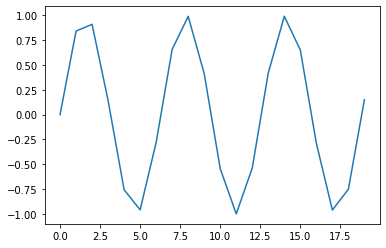

In [ ]:
## set up some sample data
sample_sin = torch.tensor(np.sin(np.arange(20)))[None,:] #one channel
plt.plot(sample_sin[0]);

t = torch.randn((4,20))
ts_tensor = TSTensor(t)

#### Helper Function

In [ ]:
def _get_sin(dims=(1,20)): return torch.tensor([np.sin(x) for x in np.arange(dims[1])]).unsqueeze(0)
def _get_log(dims=(1,20)): return torch.tensor([np.log(x+1) for x in np.arange(dims[1])]).unsqueeze(0)

In [ ]:
def _get_sample_tensor(seq_len=20):
    x = np.arange(seq_len)
    return torch.stack([tensor(np.sin(x)), torch.ones(seq_len), torch.rand(seq_len)])


In [ ]:
t = _get_sample_tensor()

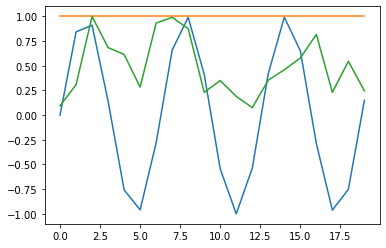

In [ ]:
for c in t:
    plt.plot(c)

Cubic Splines are used for smooth, piecewise interpolation of a sequence of datapoints
- piecewise cubic polynomials
- twice continuously differentiable, i.e. smooth

We use cubic splines both to create random curves for sampling noise for warping and interpolating data points in the case of x-axis noise.

In the example below, we add some noise to our sample data and interpolate the data points with a cubic spline. Since we now have a continuous interpolation of the original data, we can add noise to the x-axis, the interval [0:19] and use the corresponding interpolation values.

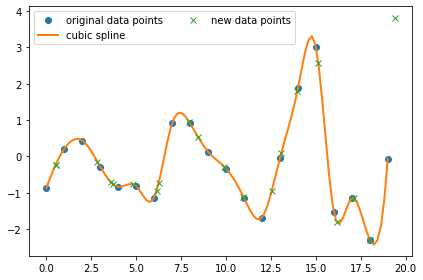

In [ ]:
rand_noise = torch.randn(sample_sin.shape)
sample_sin = sample_sin+rand_noise
plt.plot(sample_sin[0], 'o', linewidth=1, label='original data points');
cspline = CubicSpline(np.arange(20), sample_sin[0])
plt.plot(np.linspace(0,19, num=100), cspline(np.linspace(0,19, num=100)), linewidth=2, label='cubic spline');
xs_noise = np.arange(20)+np.random.normal(0,0.4, size=20)
plt.plot(xs_noise, cspline(xs_noise), 'x', label='new data points')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show();

In [ ]:
#exports
def _create_random_curve(n_channels, seq_len, magnitude, order):
    '''
    create a random curve for each channel in the interval[0, seq_len-1] on order random points
    '''
    x = np.linspace(0, seq_len-1, order)
    y = np.random.normal(loc=1.0, scale=magnitude, size=(n_channels, len(x)))
    f = CubicSpline(x, y, axis=-1)
    return f

def noise_from_random_curve(dim, magnitude=.1, order=4):
    '''
    sample points from a gaussian with mean 1 and create a smooth cubic "random curve" from these points
    ts, needs to be 2D
    order: number of sample to create the random curve from
    '''
    n_channels, seq_len = dim
    f = _create_random_curve(n_channels, seq_len, magnitude, order)
    return torch.tensor(f(np.arange(seq_len)))

def noise_from_normal(dim, magnitude=.1):
    '''
    sample random noise from a gaussian with mean=1.0 and std=magnitude
    '''
    n_channels, seq_len = dim
    return torch.tensor(np.random.normal(loc=1.0, scale=magnitude, size=(n_channels, seq_len)))

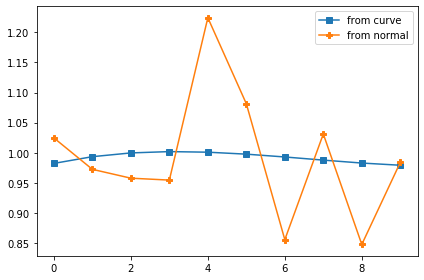

In [ ]:
t = (1,10)
plt.plot(noise_from_random_curve(t).T, marker='s', label='from curve')
plt.plot(noise_from_normal(t).T, marker='P', label='from normal')
plt.legend()
plt.tight_layout();

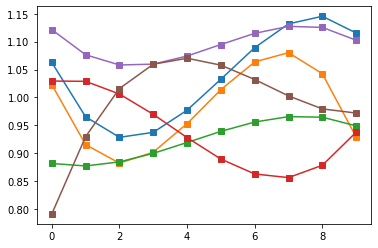

In [ ]:
plt.plot(noise_from_random_curve((6,10)).T, marker='s');

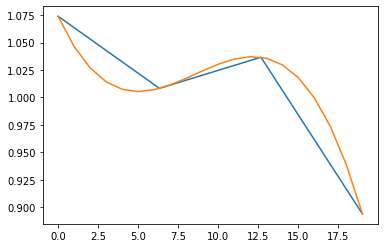

In [ ]:
samples = np.random.normal(loc=1.0, scale=0.1, size=4)
plt.plot(np.linspace(0,19,4), samples);
rcurve = CubicSpline(np.linspace(0,19,4), samples)
# plt.plot(np.linspace(0,19,100), rcurve(samples));

plt.plot(rcurve(np.arange(20)));

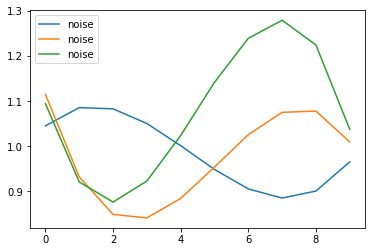

In [ ]:
#multiple channels
plt.plot(noise_from_random_curve((3,10)).T, label='noise')
plt.legend();

In [ ]:
n_channels = 3; seq_len=20; magnitude=0.2
noise = torch.normal(0, magnitude, (n_channels, seq_len))
noise.shape, noise_from_normal((n_channels, seq_len)).shape

(torch.Size([3, 20]), torch.Size([3, 20]))

#### Y Noise

In [ ]:
#export
def _ynoise(x, magnitude=.1, add=True, smooth=True, **kwargs):
    '''
    add random noise to timeseries values
    '''
#     assert isinstance(x, Tensor)
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    if magnitude <= 0: return x
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    noise_fn = noise_from_random_curve if smooth else noise_from_normal
    
    noise = noise_fn((n_channels, seq_len), magnitude=magnitude, **kwargs).to(x.device)
    if add:
        output = x + (noise-1)
        return output.to(x.device, x.dtype)
    else:
        output = x * (noise)
        return output.to(x.device, x.dtype) 

In [ ]:
#export
_ynoise_warp = partial(_ynoise, smooth=True)
_ynoise_normal = partial(_ynoise, smooth=False)
_ynoise_normal_mul = partial(_ynoise, smooth=False, add=False)

In [ ]:
def _test_aug_func(fn):
    '''
    sanity checks for augmentation functions
    '''
    t1 = torch.randn(10,100)
    t2 = torch.randn(128,10,100)
    assert fn(t1).shape == t1.shape
    assert fn(t2).shape == t2.shape
    assert fn(t1.cuda()).shape == t1.shape
    assert fn(t2.cuda()).shape == t2.shape    
    assert fn(t2.cuda()).device == t2.cuda().device

In [ ]:
_test_aug_func(_ynoise_warp)
_test_aug_func(_ynoise_normal)
_test_aug_func(_ynoise_normal_mul)

In [ ]:
def _plot_aug_func(func, magnitude=0.3):
    ts = _get_sample_tensor()
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))
    for i,t in enumerate(ts):
         axes[i].plot(t, label='orig')
    
    
    for i,t in enumerate(func(ts, magnitude=magnitude)):
        axes[i].plot(t, marker='d', linestyle='dashed', label='augmented')
#         plt.plot(t, label='orig')
#         plt.plot(_ynoise_warp(t), label='smooth')
#         plt.plot(_ynoise_normal(t), label='normal')
        plt.legend()
    plt.tight_layout();

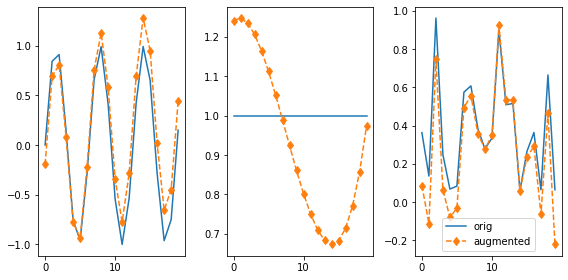

In [ ]:
_plot_aug_func(_ynoise_warp)

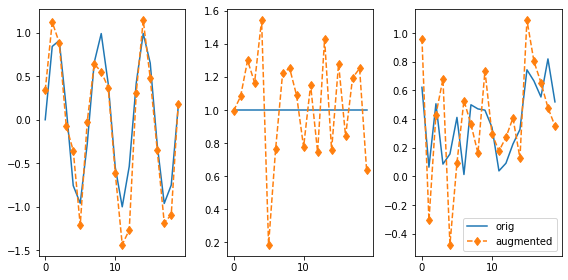

In [ ]:
_plot_aug_func(_ynoise_normal)

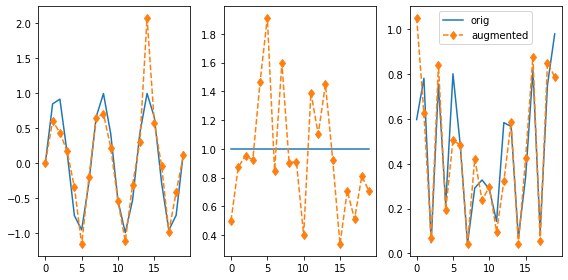

In [ ]:
_plot_aug_func(_ynoise_normal_mul, magnitude=0.4)

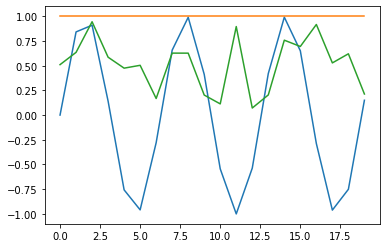

In [ ]:
t=_get_sample_tensor()
plt.plot(t.T);

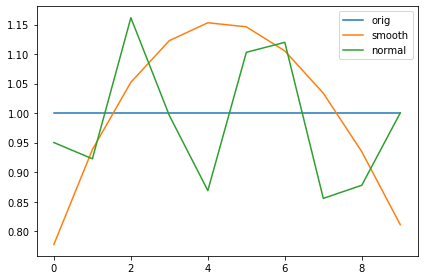

In [ ]:
t = torch.ones(1,10)
plt.plot(t.T, label='orig')
plt.plot(_ynoise_warp(t).T, label='smooth')
plt.plot(_ynoise_normal(t).T, label='normal')
plt.legend()
plt.tight_layout();

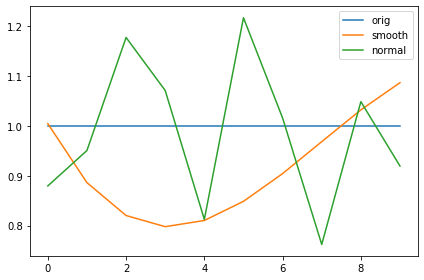

In [ ]:
t = torch.ones(1,10)
plt.plot(t.T, label='orig')
plt.plot(_ynoise_warp(t, add=False).T, label='smooth')
plt.plot(_ynoise_normal(t, add=False).T, label='normal')
plt.legend()
plt.tight_layout();

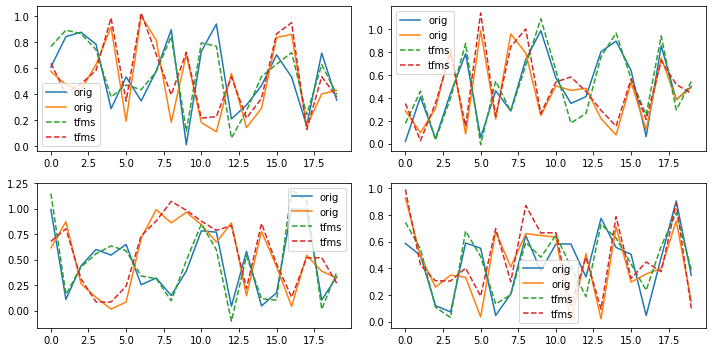

In [ ]:
## batch transform
t = torch.rand(4,2,20)
t_tfmd = _ynoise_normal(t)
_, axes = plt.subplots(2,2, figsize=(10,5))
for i,ax in enumerate(axes.flatten()):
    ax.plot(t[i].T, label='orig')
    ax.plot(t_tfmd[i].T, linestyle='dashed', label = 'tfms')
    ax.legend()
plt.tight_layout()

In [ ]:
#export
# smooth does not make sense probably unless there is some channel dependence and ordering
def _yscale(x, magnitude=.1, normal=False, by_channel=False):
    if magnitude <= 0: return x
    if normal: 
        scale = 1.+2*(torch.randn(1 if not by_channel else x.shape[-2])-0.5)*magnitude
    else:
#         scale = 1 + torch.rand(1) * magnitude  # uniform [0:1], normal possible
        scale = 1.+2*(torch.rand(1 if not by_channel else x.shape[-2])-0.5)*magnitude
#         if np.random.rand() < .5: scale = 1 / scale # scale down
#     output = x * scale.to(x.device)
    return x*scale.to(x.device) if not by_channel else x*scale[..., None].to(x.device)

In [ ]:
_test_aug_func(partial(_yscale, by_channel=False))
_test_aug_func(partial(_yscale, by_channel=True))
_test_aug_func(partial(_yscale, normal=True, by_channel=True))

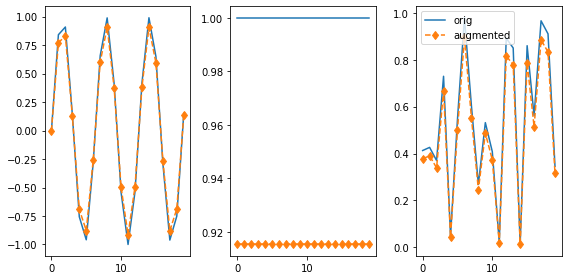

In [ ]:
_plot_aug_func(partial(_yscale, by_channel=False))

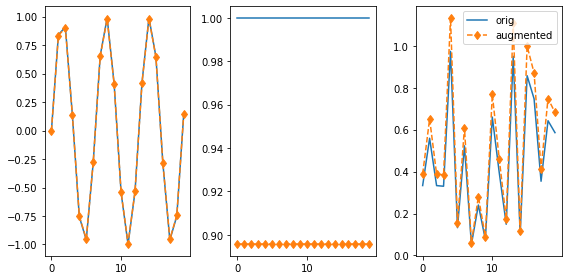

In [ ]:
_plot_aug_func(partial(_yscale, by_channel=True))

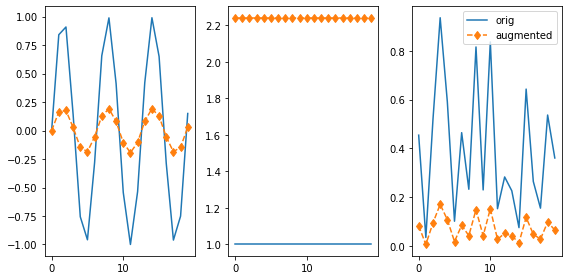

In [ ]:
_plot_aug_func(partial(_yscale, by_channel=True, normal=True))

In [ ]:
t1 = torch.ones((2,4,2))
print(_yscale(t1, by_channel=True))
print(_yscale(t1, by_channel=False))

tensor([[[1.0051, 1.0051],
         [1.0744, 1.0744],
         [1.0813, 1.0813],
         [1.0889, 1.0889]],

        [[1.0051, 1.0051],
         [1.0744, 1.0744],
         [1.0813, 1.0813],
         [1.0889, 1.0889]]])
tensor([[[1.0405, 1.0405],
         [1.0405, 1.0405],
         [1.0405, 1.0405],
         [1.0405, 1.0405]],

        [[1.0405, 1.0405],
         [1.0405, 1.0405],
         [1.0405, 1.0405],
         [1.0405, 1.0405]]])


tensor([0, 1, 2, 3, 4]) tensor([0.0000, 1.0341, 2.0681, 3.1022, 4.1362]) tensor([0.0000, 0.9941, 1.9881, 2.9822, 3.9763])


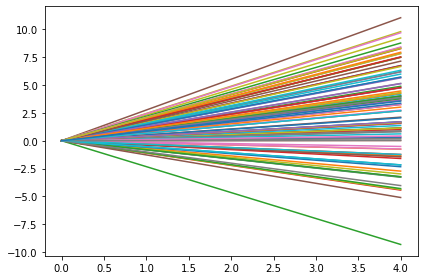

In [ ]:
t = torch.arange(5)
print(t,_yscale(t), _yscale(t, normal=True))
plt.plot(t, t.T, label='original')
for _ in range(100):
    plt.plot(t, _yscale(t, magnitude=0.5, normal=True).T, label='uniform')
# plt.plot(t, _yscale(t, magnitude=0.5, normal=True).T, label='normal')
# # plt.plot(_ynoise_normal(t, add=False).T, label='normal')
# plt.legend()
plt.tight_layout();

### Distorting the X-axis (Time)

#### Time Warping

In [ ]:
#export
def _normalize_timesteps(timesteps):
    '''
    distorted timesteps in [0,..,seq_len]
    '''
#     timesteps = timesteps - np.expand_dims(timesteps[:,0], -1)
#     timesteps = timesteps.clone()
    timesteps = timesteps.sub(timesteps[:,0].unsqueeze(-1))

#     timesteps = timesteps/np.expand_dims(timesteps[:,-1], -1) * (timesteps.shape[1]-1)
    timesteps=timesteps.div(timesteps[:,-1].unsqueeze(-1)) * (timesteps.shape[1]-1)
    
    return timesteps
    

def distort_time(dim, magnitude=.1, smooth=False, **kwargs):
    '''
    distort the time steps (x-axis) of timeseries
    '''
    n_channels, seq_len = dim
    noise_fn = noise_from_random_curve if smooth else noise_from_normal
    noise = noise_fn((n_channels, seq_len), magnitude=magnitude, **kwargs)
    time_new = _normalize_timesteps(noise.cumsum(1))
#     noise_cum = noise_cum - np.expand_dims(noise_cum[:,0], -1)
#     noise_cum = noise_cum/np.expand_dims(noise_cum[:,-1], -1) * (ts.shape[1]-1)
#     x /= x[-1]
#     x = np.clip(x, 0, 1)
#     print(x)
#     return x * (ts.shape[-1] - 1)
    return time_new

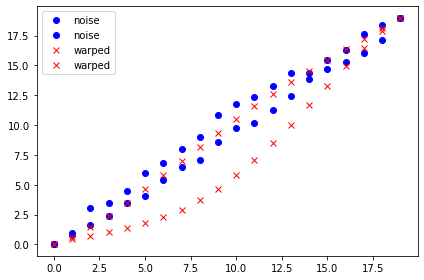

In [ ]:
t=(2,20)
plt.plot(distort_time(t, 0.5).T, 'bo', label='noise')
plt.plot(distort_time(t, 0.5, smooth=True).T, 'rx', label='warped')
plt.legend()
plt.tight_layout();


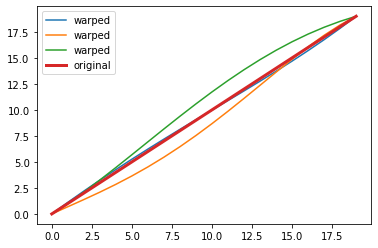

In [ ]:
plt.plot(distort_time((3,20), magnitude=0.3, smooth=True).T, label='warped')
plt.plot(np.arange(20), label='original', linewidth=3)
plt.legend();

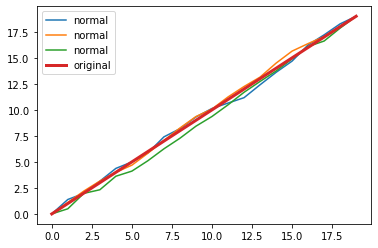

In [ ]:
plt.plot(distort_time((3,20), magnitude=0.3).T, label='normal')
plt.plot(np.arange(20), label='original', linewidth=3)
plt.legend();

In [ ]:
#export
def _timenoise(x, magnitude=.1, smooth=False, **kwargs):
    '''This is a slow batch tfm on cpu'''
    if magnitude <= 0: return x
#     if len(x.shape)==1: x=x.unsqueeze(0) #no support for 1D tensors
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu() ## only works on cpu
    
#    return f
#     plt.plot(x.T)
#     plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
    new_x = distort_time((n_channels,seq_len), magnitude=magnitude, smooth=True, **kwargs).to(x.device)
    fs = [CubicSpline(np.arange(seq_len), x[...,i,:], axis=-1) for i in range(n_channels)]
#     new_y = f(new_x, )
#     print(fs(new_x).shape)
#     return new_x
    new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)])
    if len(x.shape)==3: new_y = new_y.permute(1,0,2)
    
    return new_y.to(x_device, x.dtype)

In [ ]:
#export
def _timewarp(x, magnitude=.1, order=4):
    return _timenoise(x, magnitude, smooth=True, order=order)
def _timenormal(x, magnitude=.1):
    return _timenoise(x, magnitude, smooth=False)

In [ ]:
_test_aug_func(_timewarp)
_test_aug_func(_timenormal)

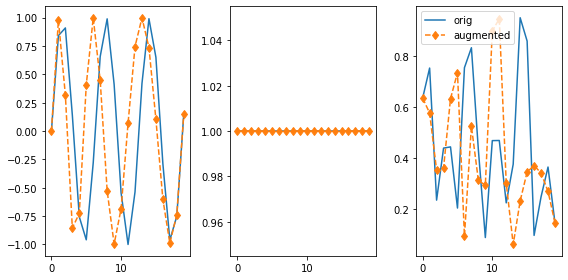

In [ ]:
_plot_aug_func(_timewarp)

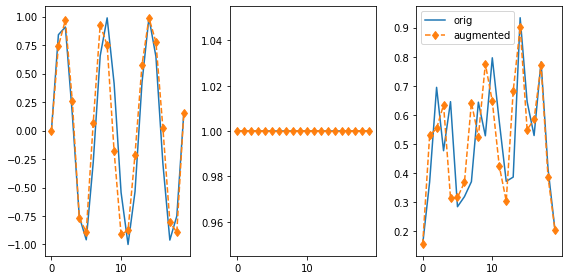

In [ ]:
_plot_aug_func(_timenormal)

#### Zoom

In [ ]:
#export
def _randomize(p):
    p = np.random.beta(p,p)
    return np.maximum(p, 1-p)

In [ ]:
#export
def _rand_steps(n, p, rand=False, window=False):
    if rand: p = _randomize(p)
    n_steps = int(p*n)        
    if window:
        start = np.random.randint(0, n-n_steps+1)
        return np.arange(start, start+n_steps)
    else: return np.sort(np.random.choice(n, n_steps, replace=False))    

In [ ]:
_rand_steps(10, 0.4, window=True, rand=True)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
#export
def _zoom(x, magnitude=.2, rand=False, zoomout=False, window=True, verbose=False):
    '''This is a slow batch tfm
    win_len: zoom into original ts into a section consisting of win_len original data points
    randomly choose one of the seq_len-win_len possible starting points for that section
    within that section, consider seq_len(number of original datapoints) evenly distributed new datapoints 
    and interpolate the respective values with a cubic spline 
    '''
    if magnitude == 0: return x
#     x_device = x.device ## make sure to put outpout on right device
#     x=x.cpu() ## only on cpu with CubicSpline

    n_channels, seq_len = x.shape[-2], x.shape[-1]
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    
    window=_rand_steps(seq_len, 1-magnitude, rand=rand, window=window)
    if zoomout: window=np.arange(seq_len-len(window), seq_len)
    pv(window, verbose)
#     x2 = x[..., window]
    fs = [CubicSpline(np.arange(len(window)), x[...,i, window].cpu(), axis=-1) for i in range(n_channels)]
    output = torch.stack(
        [torch.tensor(fs[i](np.linspace(0,len(window)-1, num=seq_len))) for i in range(n_channels)])
    if len(x.shape)==3: output = output.permute(1,0,2)
#     output = x.new(f(np.linspace(0, len(window) - 1, num=seq_len)))
    
#     new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)])
#     if len(x.shape)==3: new_y = new_y.permute(1,0,2)
    
#     return new_y.to(x_device, x.dtype)
    
    
    return output.to(x.device, x.dtype)


In [ ]:
#export
_zoomin = partial(_zoom, rand=True)
_zoomout = partial(_zoom, rand=True, zoomout=True)

def _randzoom(x, magnitude=.2):
    p = np.random.rand()
    return _zoomin(x, magnitude) if p<0.5 else _zoomout(x, magnitude)

In [ ]:
_test_aug_func(_zoomin)
_test_aug_func(_zoomout)
_test_aug_func(_randzoom)

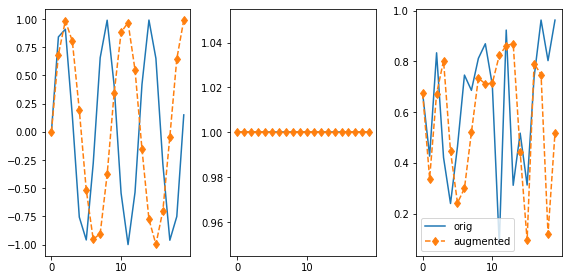

In [ ]:
_plot_aug_func(_zoomin)

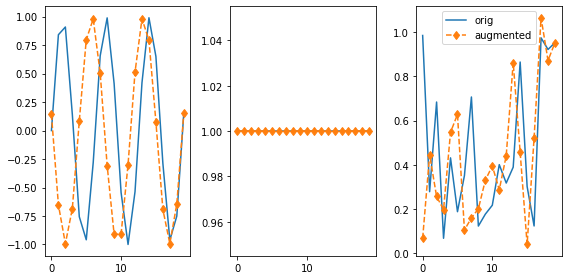

In [ ]:
_plot_aug_func(_zoomout)

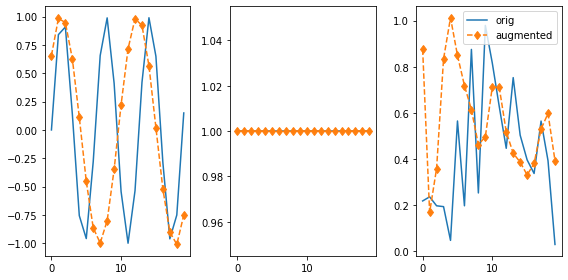

In [ ]:
_plot_aug_func(_randzoom)

#### Random Timesteps

Essentially like zoomin, but non-consecutive timesteps

In [ ]:
#export
_randtimesteps = partial(_zoom, window=False)    

In [ ]:
_test_aug_func(_randtimesteps)

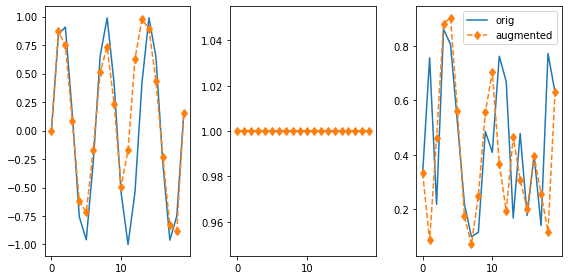

In [ ]:
_plot_aug_func(_randtimesteps)

#### Erasing Transforms

Again, these transforms sample timesteps (consecutive or non-consecutive). Instead of interpolating into the sampled timesteps, here the sampled timesteps are replaced with some other value, e.g., zero, or the mean.

In [ ]:
#export
def _complement_steps(n, steps, verbose=False):
    pv('complement', verbose)
    pv(n, verbose)
    pv(steps, verbose)
    return np.sort(np.array(list(set(n)-set(steps))))

In [ ]:
#export
def _center_steps(n, steps):
    start = n//2-len(steps)//2
    return np.arange(start, start+len(steps))

In [ ]:
#export
def _create_mask_from_steps(x, steps, dim=False):
    '''create a 2D mask'''
    mask = torch.zeros_like(x, dtype=torch.bool)
#     print(mask.shape)
#     print(steps)
#     print(mask[steps,:])
#     print(mask[:, steps])
    if dim:
        mask[steps, :] = True
    else:
        mask[:, steps] = True
    return mask

In [ ]:
#export
def _erase(x, magnitude=.2, rand=False, window=False, mean=False, complement=False, center=False, mask=False,
          dim=False, verbose=False):
    '''erasing parts of the timeseries'''
    if magnitude==0: return x
    
    pv(f'_erase input shape {x.shape}', verbose)
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    is_batch = len(x.shape)==3
    
    pv(x.shape, verbose)
    
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    p = 1-magnitude if complement else magnitude
    
    n = n_channels if dim else seq_len
    steps = _rand_steps(n, p, rand=rand, window=window)
    if center: steps = _center_steps(n, steps)
    if complement: steps = _complement_steps(np.arange(n), steps, verbose=verbose)
        
    pv(f'steps {steps}', verbose)
    output = x.clone()
    if not is_batch: output.unsqueeze_(0)
    value = 0 if not mean else output.mean((0,2), keepdims=True)
    mask = torch.rand_like(output[0])<magnitude if mask else _create_mask_from_steps(output[0], steps, dim=dim)
    
    pv(mask, verbose)
    pv(value, verbose)
    
    if not mean: output[..., mask] = 0
    else:
        assert mask.shape[-2] == value.shape[-2]
        output[..., mask]=0
        output.add_(mask.int().to(x.dtype).unsqueeze(0)*value)
    return output.squeeze_(0) if not is_batch else output
    

In [ ]:
#export
_timestepzero = partial(_erase)
_timestepmean = partial(_erase, mean=True)
_cutout = partial(_erase, rand=True, window=True, complement=True)
_crop = partial(_erase, window=True, complement=True)
_randomcrop = partial(_erase, window=True, rand=True, complement=True)
_centercrop = partial(_erase, window=True, rand=True, center=True,complement=True)
_maskout = partial(_erase, mask=True)
_dimout = partial(_erase, dim=True)

In [ ]:
for i,f in enumerate([_timestepzero, _timestepmean, _cutout, _crop, _randomcrop, _centercrop, _maskout]):
    _test_aug_func(f)

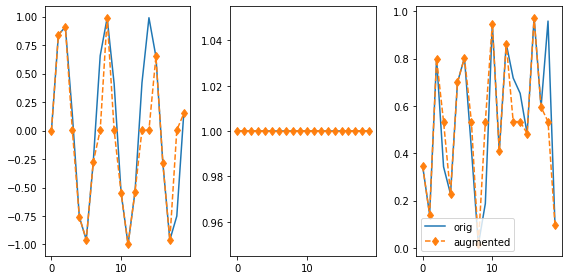

In [ ]:
_plot_aug_func(_timestepmean)

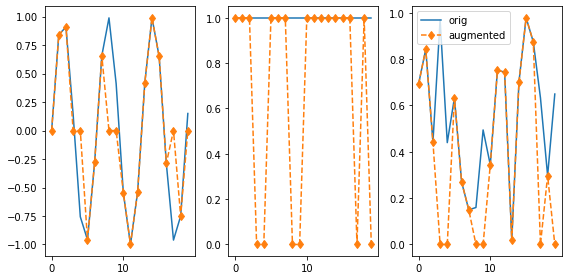

In [ ]:
_plot_aug_func(_timestepzero)

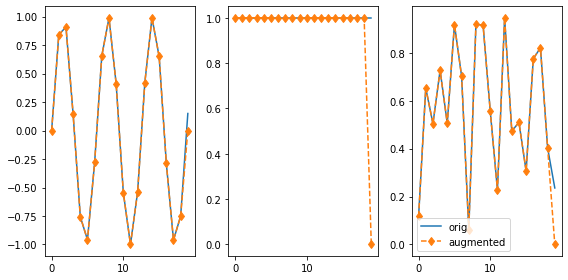

In [ ]:
_plot_aug_func(partial(_cutout, magnitude=0.4))

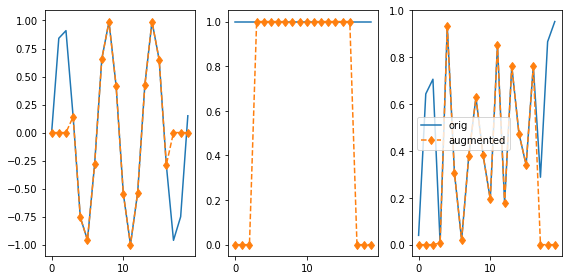

In [ ]:
_plot_aug_func(partial(_crop, magnitude=0.4))

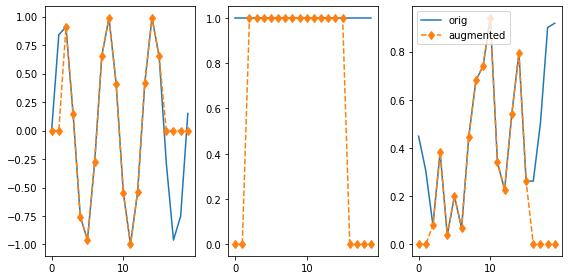

In [ ]:
_plot_aug_func(partial(_randomcrop, magnitude=0.4))

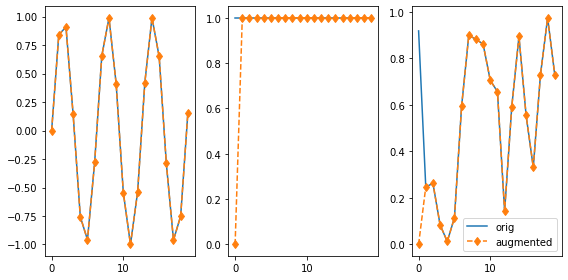

In [ ]:
_plot_aug_func(partial(_centercrop, magnitude=0.4))

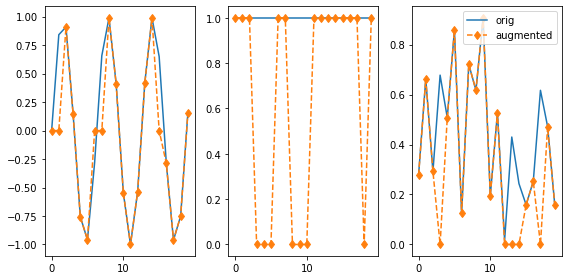

In [ ]:
_plot_aug_func(partial(_maskout, magnitude=0.4))

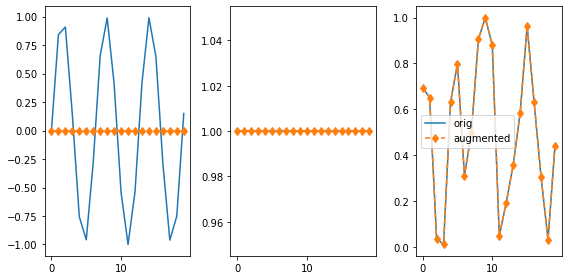

In [ ]:
_plot_aug_func(_dimout, magnitude=.4)

In [ ]:
### RandomResizedCrpp??

reference
```
class TSZoomIn(Transform):
    "Amplifies a sequence focusing on a random section of the steps"
    order = 90
    def __init__(self, magnitude=.02, ex=None, **kwargs): self.magnitude, self.ex = magnitude, ex
    def encodes(self, o: TSTensor):
        if self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = max(lambd, 1 - lambd)
        win_len = int(seq_len * lambd)
        start = 0 if win_len == seq_len else np.random.randint(0, seq_len - win_len)
        f = CubicSpline(np.arange(win_len), o[..., start : start + win_len].cpu(), axis=-1)
        output = o.new(f(np.linspace(0, win_len - 1, num=seq_len)))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

#export
class TSRandomResizedCrop(Transform):
    "Crops a section of the sequence of a random length"
    order = 90
    def __init__(self, magnitude=.01, ex=None, **kwargs): self.magnitude, self.ex = magnitude, ex
    def encodes(self, o: TSTensor):
        if self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = max(lambd, 1 - lambd)
        win_len = int(seq_len * lambd)
        if win_len == seq_len: return o
        start = np.random.randint(0, seq_len - win_len)
        f = CubicSpline(np.arange(win_len), o[..., start : start + win_len].cpu(), axis=-1)
        return o.new(f(np.linspace(0, win_len, num=seq_len)))
```

```
#export
class TSRandomResizedCrop(Transform):
    "Crops a section of the sequence of a random length"
    order = 90
    def __init__(self, magnitude=.01, ex=None, **kwargs): self.magnitude, self.ex = magnitude, ex
    def encodes(self, o: TSTensor):
        if self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = max(lambd, 1 - lambd)
        win_len = int(seq_len * lambd)
        if win_len == seq_len: return o
        start = np.random.randint(0, seq_len - win_len)
        f = CubicSpline(np.arange(win_len), o[..., start : start + win_len].cpu(), axis=-1)
        return o.new(f(np.linspace(0, win_len, num=seq_len)))
  ```

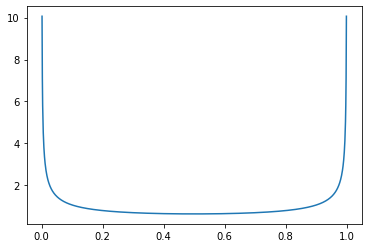

In [ ]:
import scipy.stats as ss

for mag in np.linspace(0.0, 5.9, 1):
    x = np.linspace(0,1,1000)
    y = ss.beta.pdf(x, 0.5, 0.5)
    plt.plot(x,y);

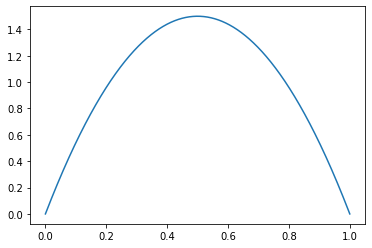

In [ ]:
x = np.linspace(0,1,1000)
y = ss.beta.pdf(x, 2, 2)
plt.plot(x,y);

### Transforms

We define augmentation `Transforms` for types `TSTensor` and `TSIntTensor`. The augmentation functions are defined for float tensors. In order to use them for discrete timeseries tensors, we cast them to float, apply the augmentations and then cast them back to TSIntTensor.
Standardization is done after augmentation, but discrete values are not cast back to int after that.

In [ ]:
# class TimeWarp(Transform):
#     order=200
#     def encodes(self, x:TSTensor):
#         print('timewarp')
#         return _timewarp(x)

In [ ]:
#export
@delegates(to=Transform.__init__) ## delegates should default to base class
class AugTransform(Transform):
    split_idx,init_enc,order,train_setup = 0,True,90,None
    def __init__(self, magnitude=0.1, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.magnitude=magnitude
        self.verbose = verbose
        
    def __call__(self, x, split_idx=split_idx):
        return super().__call__(x, split_idx=split_idx)
    
#     def encodes(self, x:TSIntTensor):
#         return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

In [ ]:
# class AugTransformInt(AugTransform):
#     def encodes(self, x:TSIntTensor):
#         return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

#### Noise

In [ ]:
#export
# @delegates(keep=True)
class YWarp(AugTransform):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
    
    def encodes(self, x:TSTensor):
        pv('ywarp', self.verbose)
        return _ynoise_warp(x, magnitude=self.magnitude)

In [ ]:
inspect.signature(YWarp.__init__)

<Signature (self, magnitude=0.1, verbose=False, **kwargs)>

In [ ]:
YWarp.mro()

[__main__.YWarp, __main__.AugTransform, fastcore.transform.Transform, object]

In [ ]:
#export
class YNormal(AugTransform):
    def encodes(self, x:TSTensor):
        pv('ynormal', verbose=self.verbose)
        return _ynoise_normal(x)
    
class YNormalMul(AugTransform):
    def encodes(self, x:TSTensor):
        pv('ynormal', verbose=self.verbose)
        return _ynoise_normal_mul(x)

In [ ]:
ts_sample=TSTensor(_get_sample_tensor())

In [ ]:
YNormal(verbose=True)(ts_sample), YNormal(verbose=False)(ts_sample)

ynormal


(TSTensor([[ 0.0942,  0.8871,  0.8593,  0.1243, -0.7154, -1.1294, -0.3167,  0.6529,
           0.9563,  0.4333, -0.4253, -0.9773, -0.6267,  0.5255,  1.1646,  0.7770,
          -0.3765, -1.0611, -0.6799,  0.2525],
         [ 0.9362,  1.1539,  0.9849,  1.1686,  1.0311,  1.0994,  1.0114,  0.9993,
           1.0239,  0.9243,  1.0089,  0.7799,  1.0385,  0.9861,  0.9588,  1.1571,
           1.0513,  1.0252,  0.9029,  1.0236],
         [ 0.7313,  0.6733,  0.5390,  0.6110,  0.4255,  0.7112,  0.0864,  1.0771,
           0.7770,  0.1822,  0.5982,  0.5044,  0.2251,  0.7148,  0.2694,  1.0722,
           0.2290,  0.5605,  0.7911,  0.5410]]),
 TSTensor([[ 0.1103,  0.9889,  0.9526,  0.1234, -0.6081, -0.9834, -0.3414,  0.5114,
           1.0914,  0.4720, -0.4896, -1.0934, -0.4828,  0.2505,  0.9298,  0.8172,
          -0.2333, -0.9702, -0.6876,  0.2007],
         [ 1.0712,  0.9226,  0.9676,  0.8189,  1.0442,  1.1601,  0.9583,  1.1610,
           0.9949,  1.1459,  0.9547,  0.9995,  0.9437,  0.9569,  0.9

In [ ]:
#export
class YScale(AugTransform):
    def encodes(self, x:TSTensor):
        pv('yscale', verbose=self.verbose)
        return _yscale(x)

In [ ]:
#export
class YScaleChannel(AugTransform):
    def encodes(self, x:TSTensor):
        pv('yscale channel', verbose=self.verbose)
        return partial(_yscale, by_channel=True)(x)

In [ ]:
#export
class TimeWarp(AugTransform):
    def encodes(self, x:TSTensor):
        pv('timewarp', verbose=self.verbose)
        return _timewarp(x)

In [ ]:
#export
class TimeNormal(AugTransform):
    def encodes(self, x:TSTensor):
        pv(f'timenormal {x.shape}', verbose=self.verbose)
        return _timenormal(x, magnitude=self.magnitude)

Experimental, include TSIntTensor 
- apply regular float transforms, but round back to int
- that might or might not make sense, application dependend

In [ ]:
@TimeNormal
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))


In [ ]:
#export
@YWarp
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
#     return cast(self.__call__(TSTensor(x.float())).int(), type(x))

@YNormal
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))    
#     return cast(self.__call__(TSTensor(x.float())).int(), type(x))
    
@YScale
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

@YScaleChannel
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x)) 

@TimeWarp
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))


In [ ]:
#export
def all_noise_augs(magnitude=0.1, verbose=False):
    kwargs = {'magnitude':magnitude, 'verbose':verbose}
    return [YWarp(**kwargs), YNormal(**kwargs), YScale(**kwargs), YScaleChannel(**kwargs),
           TimeWarp(**kwargs), TimeNormal(**kwargs)]

In [ ]:
def _test_transform(tf, tsint=True):
    '''
    sanity checks for augmentation transforms
    '''
#     t1 = torch.randn(10,100)
    t1 = TSTensor(torch.randn(128,10,100))
    if tsint: t2=TSIntTensor(torch.randint(-5,5,(128,10,100), dtype=torch.int16))
#     assert fn(t1).shape == t1.shape

    tfms = listify(tf)
    
    for t in tfms:
        assert t(t1).shape == t1.shape
        assert t(t2).shape == t2.shape
        assert t(t1.cuda()).shape == t1.shape    
        assert t(t2.cuda()).shape == t2.shape   
        assert t(t2.cuda()).dtype == t2.dtype


In [ ]:
def _plot_transform(tf, tsint=False, f=_get_sin):
    '''
    sanity checks for augmentation transforms
    '''
    t = f() if not tsint else torch.randint(-5,5,(1,20))
    ts = TSTensor(t) if not tsint else TSIntTensor(t)
    
    tfms = listify(tf)
    n_cols= min(len(tfms), 3)
    n_rows = (len(tfms)-1)//3 +1
    _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8,4), squeeze=False)

    
    for tfm, ax in zip(tfms, axes.flatten()):
#         ax = axes[i] if len(tfms)>1 else axes
        ax.plot(t.squeeze(),label='orig')
        ax.plot(tfm(ts).squeeze(), linestyle='dashed',label=f'{tfm.name}')
        ax.legend()
    plt.tight_layout()

In [ ]:
_test_transform(all_noise_augs())

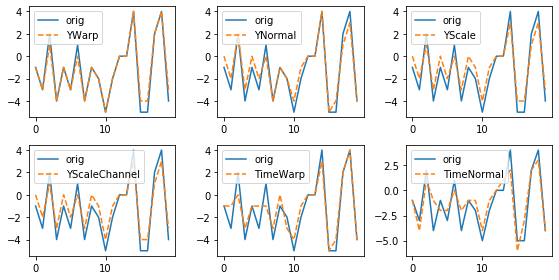

In [ ]:
_plot_transform(all_noise_augs(), tsint=True)

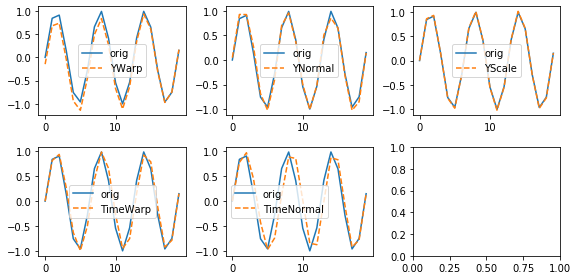

In [ ]:
_plot_transform(all_noise_augs(), tsint=False)

#### Zoom

In [ ]:
#export
class Zoomin(AugTransform):
    def encodes(self, x:TSTensor):
        pv('zoomin', verbose=self.verbose)
        return _zoomin(x, magnitude=self.magnitude)
    
class Zoomout(AugTransform):
    def encodes(self, x:TSTensor):
        pv('zoomout', verbose=self.verbose)
        return _zoomout(x, magnitude=self.magnitude)
    
class RandZoom(AugTransform):
    def encodes(self, x:TSTensor):
        pv('randzoom', verbose=self.verbose)
        return _randzoom(x, magnitude=self.magnitude)
    
class RandTimesteps(AugTransform):
    def encodes(self, x:TSTensor):
        pv('randtimestep', verbose=self.verbose)
        return _randtimesteps(x, magnitude=self.magnitude)

In [ ]:
#export
@Zoomin
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

@Zoomout
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

@RandZoom
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

@RandTimesteps
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))


In [ ]:
#export
def all_zoom_augs(magnitude=0.1, verbose=False):
    kwargs = {'magnitude':magnitude, 'verbose':verbose}
    return [Zoomin(**kwargs), Zoomout(**kwargs), RandZoom(**kwargs),
           RandTimesteps(**kwargs)]

In [ ]:
_test_transform(all_zoom_augs())

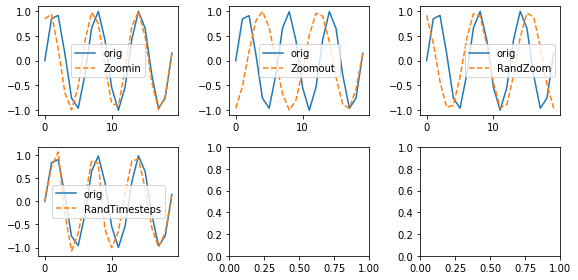

In [ ]:
_plot_transform(all_zoom_augs())

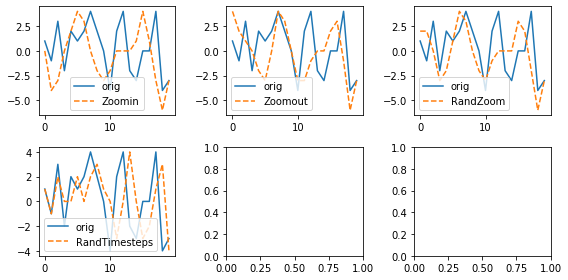

In [ ]:
_plot_transform(all_zoom_augs(), tsint=True)

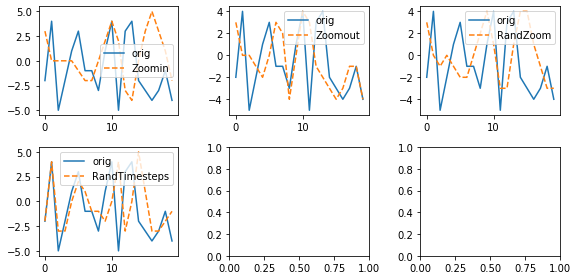

In [ ]:
_plot_transform(all_zoom_augs(), tsint=False, f=lambda:torch.randint(-5,5,(1,20)))

In [ ]:
# #export
# _timestepzero = partial(_erase)
# _timestepmean = partial(_erase, mean=True)
# _cutout = partial(_erase, window=True)
# _crop = partial(_erase, window=True, complement=True)
# _randomcrop = partial(_erase, window=True, rand=True, complement=True)
# _centercrop = partial(_erase, window=True, center=True,complement=True)
# _maskout = partial(_erase, mask=True)
# _dimout = partial(_erase, dim=True)

#### Erasing

In [ ]:
#export
class TimestepZero(AugTransform):
    def encodes(self, x:TSTensor):
        pv('timestepzero', verbose=self.verbose)
        return _timestepzero(x, magnitude=self.magnitude)

class TimestepMean(AugTransform):
    def encodes(self, x:TSTensor):
        pv('timestepmean', verbose=self.verbose)
        return _timestepmean(x, magnitude=self.magnitude)
    
class Cutout(AugTransform):
    def encodes(self, x:TSTensor):
        pv('cutout', verbose=self.verbose)
        return _cutout(x, magnitude=self.magnitude)

class Crop(AugTransform):
    def encodes(self, x:TSTensor):
        pv('crop', verbose=self.verbose)
        return _crop(x, magnitude=self.magnitude)
    
class RandomCrop(AugTransform):
    def encodes(self, x:TSTensor):
        pv('randomcrop', verbose=self.verbose)
        return _randomcrop(x, magnitude=self.magnitude)

class CenterCrop(AugTransform):
    def encodes(self, x:TSTensor):
        pv('centercrop', verbose=self.verbose)
        return _centercrop(x, magnitude=self.magnitude)
    
class Maskout(AugTransform):
    def encodes(self, x:TSTensor):
        pv('maskout', verbose=self.verbose)
        return _maskout(x, magnitude=self.magnitude)
    
class Dimout(AugTransform):
    def encodes(self, x:TSTensor):
        pv('dimout', verbose=self.verbose)
        return _dimout(x, magnitude=self.magnitude)

In [ ]:
#export
@TimestepZero
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
@TimestepMean
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
@Cutout
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
@Crop
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
@RandomCrop
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
@CenterCrop
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
@Maskout
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
@Dimout
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))


In [ ]:
#export
class CutoutMean(AugTransform):
    def encodes(self, x:TSTensor):
        pv('cutout', verbose=self.verbose)
        return partail(_cutout, mean=True)(x, magnitude=self.magnitude)
    def encodes(self, x:TSIntTensor):
        return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
    
class CenterCropMean(AugTransform):
    def encodes(self, x:TSTensor):
        pv('centercrop', verbose=self.verbose)
        return partial(_centercrop, mean=True)(x, magnitude=self.magnitude)
    def encodes(self, x:TSIntTensor):
        return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))
    

In [ ]:
#export
def all_erasing_augs(magnitude=0.1, verbose=False):
    kwargs = {'magnitude':magnitude, 'verbose':verbose}
    return [Dimout(**kwargs), Cutout(**kwargs), TimestepZero(**kwargs), Crop(**kwargs), 
            RandomCrop(**kwargs), Maskout(**kwargs)]

In [ ]:
_test_transform(all_erasing_augs())

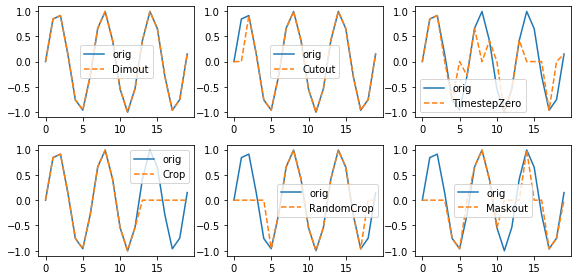

In [ ]:
_plot_transform(all_erasing_augs(magnitude=0.4))

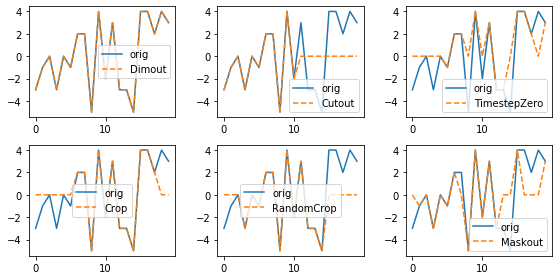

In [ ]:
_plot_transform(all_erasing_augs(magnitude=0.4), tsint=True)

In [ ]:
all_erasing_augs??

In [ ]:
#export
def all_augs(magnitude=0.3, verbose=False):
    kwargs = {'magnitude':magnitude, 'verbose':verbose}
    return all_noise_augs(**kwargs)+all_zoom_augs(**kwargs)+all_erasing_augs(**kwargs) 

### RandAugment

In [ ]:
#export
class RandAugment(AugTransform):
    '''
    choose `N` transforms randomly and apply them with magnitude `magnitude`
    '''
    def __init__(self, N=3, magnitude=0.3, tfms=None, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.N = N
        pv(f'tfms {tfms}', verbose)
        self.tfms = tfms
        if tfms is None: self.tfms = all_augs(magnitude, verbose=verbose)
            
    def encodes(self, x:TSTensor):
        fs = np.random.choice(self.tfms, self.N, replace=False)
        return compose_tfms(x, fs)
    
    def encodes(self, x:TSIntTensor):
        return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

In [ ]:
_test_transform(RandAugment())

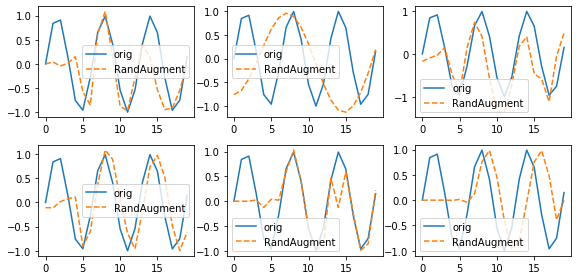

In [ ]:
_plot_transform([RandAugment()]*6)

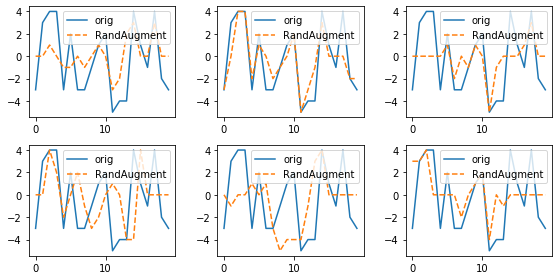

In [ ]:
_plot_transform([RandAugment()]*6, tsint=True)

### Augmix

In [ ]:
#export
class Augmix(AugTransform):
    def __init__(self, N=3, magnitude=0.2, k=3, alpha=1, tfms=None, verbose=False, **kwargs):
        '''
        N: number of operations per update
        k: number of update operations
        alpha: beta and dirichlet parameter
        '''
        super().__init__(**kwargs)
        self.N, self.k, self.alpha, self.verbose = N, k, alpha, verbose
#         print(f'tfms {tfms}')
        self.tfms = tfms
        if tfms is None: self.tfms = all_augs(magnitude, verbose=verbose)
            
            
    
            
    def encodes(self, x:TSTensor):
        x_aug = torch.zeros_like(x)
        weights = np.random.dirichlet([self.alpha]*self.k)
        m = np.random.beta(self.alpha, self.alpha)
        pv(f'weights {weights}, m {m}', self.verbose)
        for i in range(self.k):
            fs = np.random.choice(self.tfms, self.N, replace=False)
            n = np.random.randint(self.N)
            pv(f'ops in step {i} {fs[:n+1]}', self.verbose)
            x_aug += weights[i]*compose_tfms(x, fs[:n+1]) ## normalize?
        return m*x + (1-m)*x_aug
    
    def encodes(self, x:TSIntTensor):
        return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

In [ ]:
#export
class AugmixSS(AugTransform):
    '''
    augmix with standardization
    '''
    def __init__(self, N=3, magnitude=0.3, k=3, alpha=1, tfms=None, verbose=False, 
                 mean=None, std=None, **kwargs):
        '''
        N: number of operations per update
        k: number of update operations
        alpha: beta and dirichlet parameter
        '''
        super().__init__(**kwargs)
        
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        
        self.N, self.k, self.alpha, self.verbose = N, k, alpha, verbose
#         print(f'tfms {tfms}')
        self.tfms = tfms
        if tfms is None: self.tfms = all_augs(magnitude, verbose=verbose)
        self.axes=(0,2) #hard coded for now
            
            
    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            #pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
#             x, *_ = dl.one_batch() ##??
            x = dl.ptls[0] ## modification
            self.mean = x.mean(self.axes, keepdim=self.axes!=()).to(default_device()) 
            self.std =  x.std(self.axes, keepdim=self.axes!=()).to(default_device()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)
            
    def _normalize(self,x):
        return (x-self.mean)/self.std
    
            
    def encodes(self, x:TSTensor):
        x_aug = torch.zeros_like(x)
        weights = np.random.dirichlet([self.alpha]*self.k)
        m = np.random.beta(self.alpha, self.alpha)
        pv(f'weights {weights}, m {m}', self.verbose)
        for i in range(self.k):
            fs = np.random.choice(self.tfms, self.N, replace=False)
            n = np.random.randint(self.N)
            pv(f'ops in step {i} {fs[:n+1]}', self.verbose)
            x_aug += weights[i]*self._normalize(compose_tfms(x, fs[:n+1])) ## normalize?
        return m*self._normalize(x) + (1-m)*x_aug
    
#     def encodes(self, x:TSIntTensor):
#         return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

In [ ]:
_test_transform(AugmixSS( mean=0.1, std=0.5))
_test_transform(Augmix())

tfms None


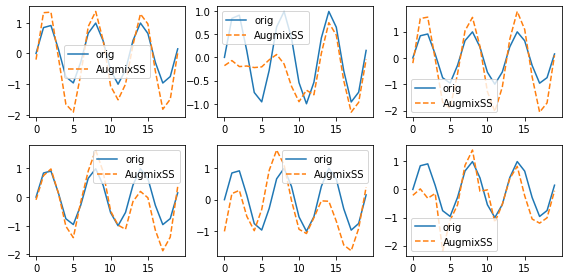

In [ ]:
_plot_transform([AugmixSS( mean=0.1, std=0.5, verbose=False)]*6)

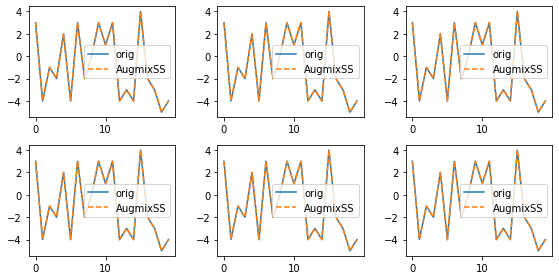

In [ ]:
_plot_transform([AugmixSS( mean=0.1, std=0.5, verbose=False)]*6, tsint=True)

tfms None


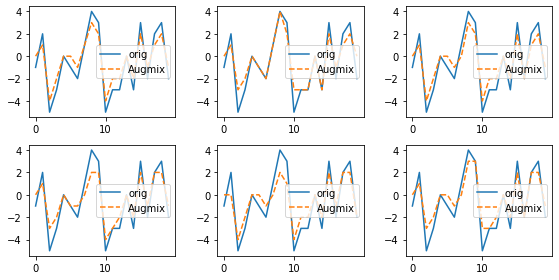

In [ ]:
_plot_transform([Augmix()]*6, tsint=True)

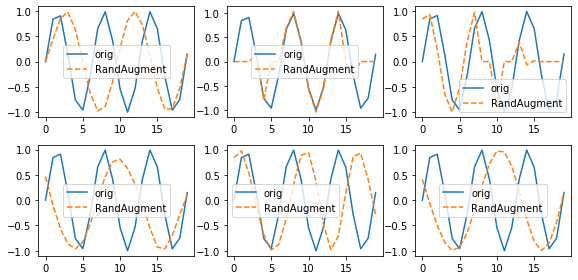

In [ ]:
_plot_transform([RandAugment()]*6)

### Integration Example

In [ ]:
nrows = 20000
df_main = pd.read_csv('./data/custom/bi_sample_anon.csv', nrows=nrows)

In [ ]:
from torchtools.configs import *
config_id =  'anon_10sl_4c_2d_2y'
col_config = read_config(config_id, 'config2.json')

In [ ]:
cols_c, cols_d, cols_y = L(['cols_c', 'cols_d', 'cols_y']).map(col_config.get)
n_train = 10000

In [ ]:
items = items_from_df(df_main, cols_c, cols_y, n_train, cols_d=cols_d)

(20000, 4, 10)
(20000, 2, 10)


In [ ]:
Xc,Xd,y = items_to_arrays(items)

In [ ]:
splits=TSSplitter()(df_main.iloc[:1000])
dsets = TSDatasets3(X=Xc[:1000], X_dis=Xd[:1000], y=y[:1000], splits=splits, inplace=True)
batch_tfms = [TSStandardize(by_var=True), TSStandardize(by_var=True, discrete=True), RandAugment()]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0, batch_tfms=batch_tfms)

In [ ]:
#test
#basic modelling
from fastai2.basics import *
model = InceptionTimeD(6,2)
loss_fn = get_loss_fn('leaky_loss', alpha=0.5)
learn_small = Learner(model=model, loss_func=loss_fn, dls=dls, metrics=unweighted_profit)

In [ ]:
learn_small.fit_one_cycle(3)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.104474,-0.135208,-0.843776,00:00
1,-0.310715,-0.177581,-0.979860,00:00
2,-0.486506,-0.204857,-0.774362,00:00
